## Workshop: GMM gender detector

Credits: https://github.com/abhijeet3922/PyGender-Voice

<img src='assets/speech/workshop1_pygender.png' style='float:right'/>

1. Download data from [here](
https://www.dropbox.com/s/hcku4t7alrhacqv/pygender.zip?dl=0)

2. Extract the .zip file to a folder of your choice. Note down the path as you will need to enter it in the workshop code.

In [15]:
!pip3 install python_speech_features

import os
from os.path import basename, join
import numpy as np

import python_speech_features as mfcc
from scipy.io.wavfile import read
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

TRAIN_PATH = 'C:\\mldds\\pygender\\train_data\\youtube\\' # modify to your actual path

thinc 6.10.2 requires pathlib<2.0.0,>=1.0.0, which is not installed.
spacy 2.0.8 requires pathlib, which is not installed.
notebook 5.4.0 requires ipykernel, which is not installed.
jupyter 1.0.0 requires ipykernel, which is not installed.
jupyter-console 5.2.0 requires ipykernel, which is not installed.
ipywidgets 7.1.1 requires ipykernel>=4.5.1, which is not installed.
tensorboard 1.6.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.2 which is incompatible.
tensorboard 1.6.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
spacy 2.0.8 has requirement html5lib==1.0b8, but you'll have html5lib 1.0.1 which is incompatible.
spacy 2.0.8 has requirement regex==2017.4.5, but you'll have regex 2017.11.9 which is incompatible.
requests 2.18.4 has requirement chardet<3.1.0,>=3.0.2, but you'll have chardet 2.3.0 which is incompatible.


In [16]:
def get_MFCC(audio_file, scale=True):
    '''Computes the Mel-frequency ceptrum coefficients for an audio file,
    with optional scaling
    See: https://github.com/jameslyons/python_speech_features
    '''
    sample_rate, audio = read(audio_file)
    features = mfcc.mfcc(audio, sample_rate, winlen=0.025, winstep=0.01, numcep=13, appendEnergy=False)
    if scale:
        features = preprocessing.scale(features) # scale to (0, 1)
    return features

In [17]:
# Playback a sample file
from IPython import display

sample_file = join(TRAIN_PATH, 'male', 'male1.wav')
sample_rate, audio = read(sample_file)
display.Audio(data=audio, rate=sample_rate)

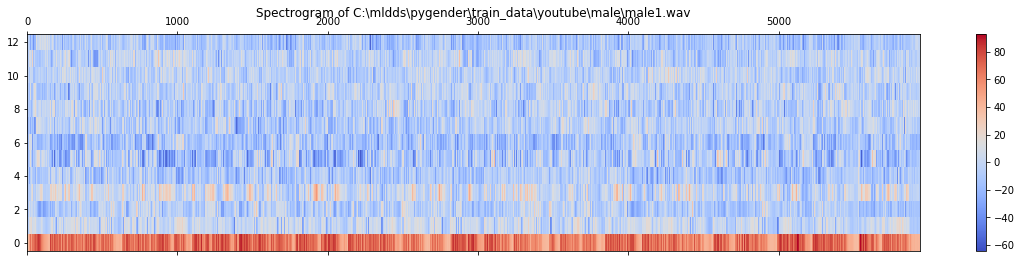

In [18]:
# Plot the MFCC
import matplotlib.pyplot as plt

mfcc_vector = get_MFCC(sample_file, scale=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(mfcc_vector), interpolation='nearest', aspect='auto', cmap='coolwarm', origin='lower')
fig.colorbar(cax)
plt.title("Spectrogram of {}".format(sample_file))
plt.show()

In [19]:
def train_GMM(data_path, n_components=8, covariance_type='diag'):
    '''Trains a Gaussian mixture model for a given label and data path'''
    files = [join(data_path, f) for f in os.listdir(data_path) if f.endswith('.wav')]
    features = np.asarray(());

    for f in files:
        mfcc_vector = get_MFCC(f)

        if features.size:
            features = np.vstack((features, mfcc_vector))
        else:
            features = mfcc_vector

    # http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type,
                          max_iter=200, n_init=3)
    gmm.fit(features)
    
    # print some metrics applicable to GMMs
    print('BIC: ', gmm.bic(features), ', AIC: ', gmm.aic(features))
    return gmm

In [20]:
models = dict()
%time models['male'] = train_GMM(join(TRAIN_PATH, 'male'), n_components=8, covariance_type='diag')

# ==================================================================
# Exercise:
# Add code below to train the female model, using the above as an example

## === ANSWER === ##
%time models['female'] = train_GMM(join(TRAIN_PATH, 'female'), n_components=8, covariance_type='diag')
## === ANSWER === ##

# ==================================================================
# Optional Exercises:
# a. Try different values of n_component (e.g. 2, 16)
# b. Try different values of covariance_type (e.g. full)
#
# See http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# on how to interpret the BIC and AIC metrics for selecting models

BIC:  999718.2588105827 , AIC:  997930.6262205723
Wall time: 2.62 s
BIC:  1007587.9948838889 , AIC:  1005801.1047324421
Wall time: 2.58 s


In [21]:
def test_GMM(models, test_data_path):
    '''Tests multiple Gaussian mixture models with test data'''
    files = [os.path.join(test_data_path,f) for f in os.listdir(test_data_path)
             if f.endswith(".wav")]
    
    predictions = []
    for f in files:
        features = get_MFCC(f)
        keys = []
        log_likelihood = np.zeros(len(models))

        for i, (key, gmm) in enumerate(models.items()):
            scores = np.array(gmm.score(features))
            keys.append(key)
            log_likelihood[i] = scores.sum()

        # find the model with the maximum score
        winner = np.argmax(log_likelihood)
        # print('prediction:', keys[winner], "\tscores:", log_likelihood[winner])
        predictions.append(keys[winner])
    return predictions

[[534  24]
 [135 411]]


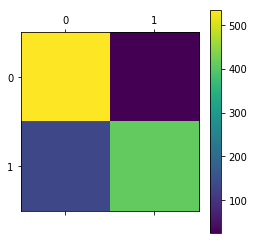

In [26]:
# ==================================================================
# Exercise:
# 1. Complete the code below to test the GMM models using test_GMM().
#    Be sure to run against both male and female models.
# 2. Plot the confusion matrix

from sklearn.metrics import confusion_matrix

TEST_PATH = 'C:\\mldds\\pygender\\test_data\\AudioSet' # modify to your actual path

## === ANSWER === ##
male_predictions = test_GMM(models, join(TEST_PATH, 'male_clips'))
female_predictions = test_GMM(models, join(TEST_PATH, 'female_clips'))

truth = ['male' for p in male_predictions] + ['female' for p in female_predictions]
cm = confusion_matrix(truth, male_predictions + female_predictions)
print(cm)
plt.matshow(cm)
plt.colorbar()
## === ANSWER === ##

## Workshop: Deep Speech